Yea we train in Jupyter now, deal with it.

In [6]:
import torch
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

from assembly_extract import OPS_LENGTH

usage: ipykernel_launcher.py [-h] [-i I] [-o O] [--dump]
ipykernel_launcher.py: error: unrecognized arguments: --ip=127.0.0.1 --stdin=9003 --control=9001 --hb=9000 --Session.signature_scheme="hmac-sha256" --Session.key=b"46c62610-c6f9-4681-8fd0-011b410f1270" --shell=9002 --transport="tcp" --iopub=9004 --f=c:\Users\tanas\AppData\Roaming\jupyter\runtime\kernel-v2-21084ikl9xzhwXrsj.json


SystemExit: 2

In [ ]:
dataset = torch.load('data/dataset.pt')

print(f"Amount of items: {len(dataset)}")

bn = 0
rs = 0

for d in dataset:
    if d.y.item() == 1:
        rs += 1
    elif d.y.item() == 0:
        bn += 1

print(f"Amount of ransomware: {rs}")
print(f"Amount of benign: {bn}")

print(dataset[0])

data_len = len(dataset)
train_amo = round(data_len * 0.8)

train_loader = DataLoader(dataset[:train_amo], batch_size=64, shuffle=True)
test_loader = DataLoader(dataset[train_amo:], batch_size=64, shuffle=False)

Amount of items: 1585
Amount of ransomware: 972
Amount of benign: 613
Data(x=[1686, 5], edge_index=[2, 1736], y=[1])


In [ ]:
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool

class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(OPS_LENGTH, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, 2)

    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        
        x = global_mean_pool(x, batch)
        
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        
        return x

In [ ]:
from config import *

100%|██████████| 32/32 [33:43<00:00, 63.25s/it]


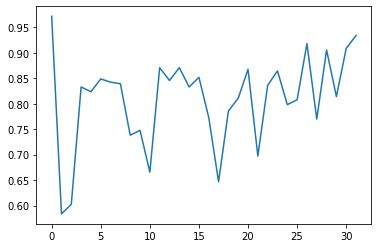

Max accuracy: 0.9716
Epoch: 031, Test Acc: 0.9338


In [ ]:
from IPython.display import Javascript
from tqdm import tqdm
import matplotlib.pyplot as plt

model = GCN(hidden_channels = latent_dim)
optimizer = torch.optim.Adam(model.parameters(), lr = lr)
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()

    for data in train_loader:
        out = model(data.x, data.edge_index, data.batch)
        loss = criterion(out, data.y)
        loss.backward()  
        optimizer.step()  
        optimizer.zero_grad()  

def test(loader):
    model.eval()

    correct = 0
    for data in loader:  
        out = model(data.x, data.edge_index, data.batch)  
        pred = out.argmax(dim = 1)  
        correct += int((pred == data.y).sum())  
    return correct / len(loader.dataset)  

acc = []
best = 0

for e in tqdm(range(EPOCH)):
    train()
    train_acc = test(test_loader)
    acc.append(train_acc)
    
    if train_acc > best:
        best = train_acc
        torch.save(model.state_dict(), WEIGHT_PATH)

plt.plot(acc)
plt.show()

print(f"Max accuracy: {max(acc):.4f}")
test_acc = test(test_loader)
print(f'Epoch: {e:03d}, Test Acc: {test_acc:.4f}, Best Acc: {best:.4f}')

## Load & Interence

In [ ]:
new_model = GCN(hidden_channels = latent_dim)
new_model.load_state_dict(torch.load(WEIGHT_PATH))
new_model.eval()

In [ ]:
from dismgrp import dismgrp

PE_PATH = ""
data = dismgrp(PE_PATH)
res = new_model(data.x, data.edge_index, data.batch)  

print(res)